<a href="https://colab.research.google.com/github/mralamdari/Machine_Learning_Projects/blob/main/Neural_Style_Transfer_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

#1.Dataset

###download a style image and a content image,also
###You can get them from [here](https://github.com/mr-alamdari/Neural-Style-Transfer-Pytorch)
###Or get them in here:[Style](https://www.wikiart.org/en/abraham-manievich/destruction-of-the-ghetto-kiev-1919), [Content](https://www.wikiart.org/en/mikhail-shibanov/portrait-of-a-g-spiridov-1772)

In [ ]:
path2content = '/content/content.jpg'
path2style = '/content/style.jpg'

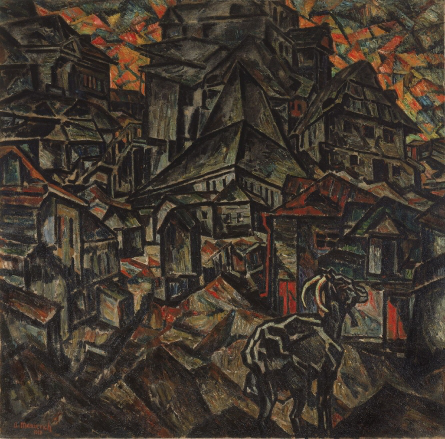

In [ ]:
style_img = Image.open(path2style)
style_img

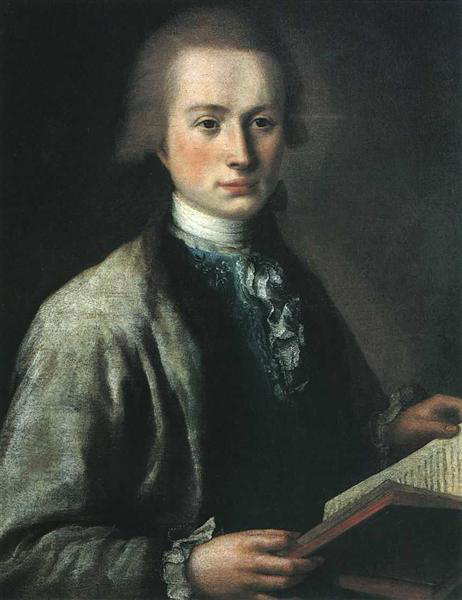

In [ ]:
content_img = Image.open(path2content)
content_img

In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
h,w = 256, 384

transformer = torchvision.transforms.Compose([
              torchvision.transforms.Resize((h, w)),
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize(mean, std)
])

In [ ]:
content_tensor = transformer(content_img)
style_tensor = transformer(style_img)
print(content_tensor.shape, content_tensor.requires_grad)
print(style_tensor.shape, style_tensor.requires_grad)

torch.Size([3, 256, 384]) False
torch.Size([3, 256, 384]) False


In [ ]:
def imgtensor2pil(img):
  img_c = img.clone().detach()
  img_c = img_c * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
  img_c = img_c.clamp(0, 1)
  img_pil = torchvision.transforms.functional.to_pil_image(img_c)
  return img_pil

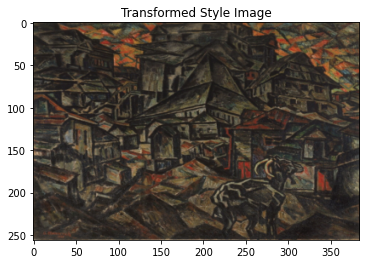

In [ ]:
plt.title('Transformed Style Image')
plt.imshow(imgtensor2pil(style_tensor))

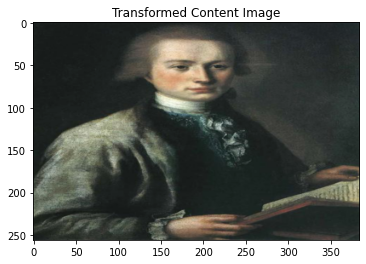

In [ ]:
plt.title('Transformed Content Image')
plt.imshow(imgtensor2pil(content_tensor))

#2.Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
for param in model.parameters():
  param.requires_grad_(False)

In [ ]:
def get_features(x, model, layers):
  features = {}
  for name, layer in enumerate(model.children()):
    x = layer(x)
    if str(name) in layers:
      features[layers[str(name)]] = x
  return features

In [ ]:
def gram_matrix(x):
  n, c, h, w = x.size()
  x = x.view(n*c, h*w)
  gram = torch.mm(x, x.t())
  return gram

In [ ]:
def get_content_loss(pred_features, target_features, layer):
  target = target_features[layer]
  pred = pred_features[layer]
  loss = torch.nn.functional.mse_loss(pred, target)
  return loss

In [ ]:
def get_style_loss(pred_features, target_features, style_layers_dict):
  loss = 0
  for layer in style_layers_dict:
    pred_fea = pred_features[layer]
    pred_gram = gram_matrix(pred_fea)
    n, c, h, w = pred_fea.shape
    target_gram = gram_matrix(target_features[layer])
    layer_loss = style_layers_dict[layer] * torch.nn.functional.mse_loss(pred_gram, target_gram)
    loss += layer_loss / (n * c * h * w)
  return loss

In [ ]:
feature_layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}

con_tensor = content_tensor.unsqueeze(0).to(device)
sty_tensor = style_tensor.unsqueeze(0).to(device)

In [ ]:
content_features = get_features(con_tensor, model, feature_layers)
style_features = get_features(sty_tensor, model, feature_layers)

In [ ]:
for key in content_features.keys():
  print(content_features[key].shape)

torch.Size([1, 64, 256, 384])
torch.Size([1, 128, 128, 192])
torch.Size([1, 256, 64, 96])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 16, 24])


In [ ]:
input_tensor = con_tensor.clone().requires_grad_(True)
# optmizer = torch.optim.Adam([input_tensor], lr=0.01)
optmizer = torch.optim.LBFGS([input_tensor], lr=0.01)

In [ ]:
style_layers_dict = {
                    'conv1_1': 0.75,
                    'conv2_1': 0.5,
                    'conv3_1': 0.25,
                    'conv4_1': 0.25,
                    'conv5_1': 0.25}
params = {
    'num_epochs': 400,
    'input_tensor': input_tensor,
    'optmizer': optmizer,
    'content_weight': 1e1,
    'style_weight': 1e4,   # 10000.0
    'style_layers_dict': style_layers_dict,
    'content_layer': 'conv5_1',
}

In [ ]:
def train_val(model, params):
  num_epochs =  params['num_epochs']
  input_tensor =  params['input_tensor']
  opt =  params['optmizer']
  content_weight =  params['content_weight']
  style_weight =  params['style_weight']
  style_layers_dict =  params['style_layers_dict']
  content_layer =  params['content_layer']

  for epoch in range(num_epochs):
    opt.zero_grad()
    
    input_features = get_features(input_tensor, model, feature_layers)
    content_loss = get_content_loss(input_features, content_features, content_layer)
    style_loss = get_style_loss(input_features, style_features, style_layers_dict)
    neural_loss = content_weight * content_loss + style_weight * style_loss
    neural_loss.backward(retain_graph=True)
    opt.step()
    
    print(f'Epoch: {epoch+1}/{num_epochs} , Content Loss: {content_loss:.4f}, Style Loss: {style_loss:.4f}')
    
  return input_tensor

In [ ]:
output = train_val(model, params)

Epoch: 1/400 , Content Loss: 2.5207, Style Loss: 6.9495
Epoch: 2/400 , Content Loss: 2.5261, Style Loss: 6.5452
Epoch: 3/400 , Content Loss: 2.5337, Style Loss: 6.1785
Epoch: 4/400 , Content Loss: 2.5462, Style Loss: 5.8398
Epoch: 5/400 , Content Loss: 2.5634, Style Loss: 5.5219
Epoch: 6/400 , Content Loss: 2.5826, Style Loss: 5.2214
Epoch: 7/400 , Content Loss: 2.6042, Style Loss: 4.9365
Epoch: 8/400 , Content Loss: 2.6266, Style Loss: 4.6673
Epoch: 9/400 , Content Loss: 2.6470, Style Loss: 4.4134
Epoch: 10/400 , Content Loss: 2.6647, Style Loss: 4.1756
Epoch: 11/400 , Content Loss: 2.6810, Style Loss: 3.9537
Epoch: 12/400 , Content Loss: 2.6965, Style Loss: 3.7472
Epoch: 13/400 , Content Loss: 2.7118, Style Loss: 3.5552
Epoch: 14/400 , Content Loss: 2.7272, Style Loss: 3.3769
Epoch: 15/400 , Content Loss: 2.7430, Style Loss: 3.2111
Epoch: 16/400 , Content Loss: 2.7593, Style Loss: 3.0569
Epoch: 17/400 , Content Loss: 2.7764, Style Loss: 2.9138
Epoch: 18/400 , Content Loss: 2.7932, St

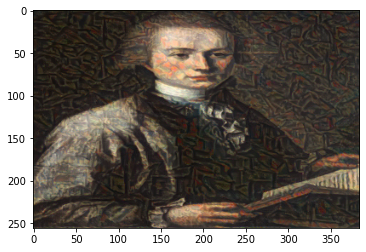

In [ ]:
plt.imshow(imgtensor2pil(output[0].cpu()))